In [1]:
import pyxdf
import os
import numpy as np
from scipy import stats
from pathlib import Path
import sys
from datetime import datetime
import pandas as pd

from utilities.utl import find_lsl_stream, find_nearest
from utilities.pupil_prep import *
from utilities.SingleSubjectData import SubjectData 

In [2]:
# (import) helper functions
dir_script = Path("__file__").parent.absolute()
dir_rawdata = Path.joinpath(dir_script.parent.absolute(), "04_data","00_raw")
print(dir_script)

C:\Users\User\Desktop\kiel\tremor_feedback_jw\05_scripts


In [3]:
f_list = os.listdir(dir_rawdata)
str_match = 'archer'
fnms = [s for s in f_list if str_match in s]


In [ ]:

ovrvw_data = []
for i,f in enumerate(fnms):
    print(f"Working on {f.split('_')[0]}")
    sub = SubjectData()
    sub.load_data(dir_rawdata,f)
    ovrvw_data.append(
        {
            'id': sub.id,
            'date': sub.date,
            'time': sub.time,
            'fname': sub.fname,
            'Max Force': sub.max_force,
            'Number of epochs': sub.n_epochs,
            'Number of trigger': sub.n_trigger,
            'SRate PupilLabs': sub.srate_ppl,
            '% bad eye data': sub.per_bad_eye
        }
    )
    

Working on c300
Max force is 4883 something
Working on c301
Max force is 5894 something
Working on c302
Stream pupil_capture not found
Max force is 6856 something
Working on c303
Max force is 8514 something
Working on c304
Max force is 5598 something
Working on c305
Max force is 11120 something
Working on c306
Max force is 8067 something
Working on c307
Max force is 7033 something
Working on c308
Max force is 11344 something
Working on c309
Max force is 5598 something
Working on p200
Max force is 15983 something
Working on p201
Max force is 9105 something
Working on p202
Max force is 4625 something
Working on p203
Max force is 7724 something
Working on p204
Max force is 4975 something
Working on p205


In [9]:
all = pd.DataFrame(ovrvw_data)
all.to_csv(Path.joinpath(dir_rawdata,'overview_data.csv'))

,id,date,time,fname,Max Force,Number of epochs,Number of trigger,SRate PupilLabs,% bad eye data
0,c300,2022-04-30,20:20:30,c300_archer_replicate.xdf,4883.0,6,28,239.817984,26.867
1,c301,2022-04-30,20:20:26,c301_archer_replicate.xdf,5894.0,14,53,239.924420,54.972
2,c302,2022-04-30,20:20:26,c302_archer_replicate.xdf,6856.0,14,59,NaN,NaN
3,c303,2022-04-30,20:20:23,c303_archer_replicate.xdf,8514.0,14,53,239.966517,36.037
4,c304,2022-04-30,20:20:19,c304_archer_replicate.xdf,5598.0,14,53,239.946143,8.256
5,c305,2022-05-31,10:55:31,c305_archer_replicate.xdf,11120.0,14,65,247.794190,24.000
6,c306,2022-06-03,13:01:19,c306_archer_replicate.xdf,8067.0,14,53,247.837853,75.021
7,c307,2022-06-03,13:02:12,c307_archer_replicate.xdf,7033.0,14,59,247.825239,6.909
8,c308,2022-04-30,20:20:43,c308_archer_replicate.xdf,11344.0,14,53,239.940512,59.507
9,c309,2021-10-27,21:59:04,c309_archer_replicate.xdf,5598.0,14,53,239.946143,8.256


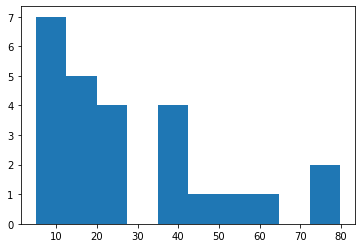

In [21]:
plt.hist(all["% bad eye data"])
all

In [44]:
# eye tracking data
nms_label_pupillab =[nm_lb['label'][0] for nm_lb in eye['info']['desc'][0]['channels'][0]['channel']]

idx_diam0_3d =  nms_label_pupillab.index('diameter0_3d')
idx_diam1_3d =  nms_label_pupillab.index('diameter1_3d')
idx_conf =  nms_label_pupillab.index('confidence')

# (1) confidence threshold
idx_conf, _ = confidence_threshold(eye['time_series'][:,idx_diam0_3d], eye['time_series'][:,idx_conf], thr=0.5, doplot=False)
# (2) delete diameter velocity outliers
idx_vout, _ = delete_velocity_outliers(eye['time_series'][:,idx_diam0_3d], whsize=10, n_mad=3, doplot=False)
# (3) eyeblink detection (Hershman et al.)
idx_blinks, _ = blink_detection(eye['time_series'][:,idx_diam0_3d], w_smooth=9, doplot=False)

# apply all deletions
diam = eye['time_series'][:,idx_diam0_3d]
diam_corr = diam.copy()
idx_corr = list(idx_conf) + list(idx_vout) + list(idx_blinks)
idx_corr = list(set(idx_corr))
diam_corr[idx_corr] = np.nan
p_corr = 1.*len(idx_corr)/len(diam)
print(f"Total proportion of deleted (NaN) data points: {p_corr:.3f}")

Apply confidence threshold
number of low-confidence data points:  15571
proportion of low-confidence data points: 0.06
Delete diameter velocity outliers (sliding window)
number of detected outliers:  0
proportion of detected outliers: 0.00
Total proportion of deleted (NaN) data points: 0.184


In [2]:
import numpy as np
a = np.nan
print(a)

nan
